In [75]:
# %pip install matplotlib
# %pip install numpy
# %pip install pandas
# %pip install seaborn

In [76]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sn

In [77]:
abm = pd.read_csv("abm.csv")
card = pd.read_csv("card.csv")
cheque = pd.read_csv("cheque.csv")
eft = pd.read_csv("eft.csv")
emt = pd.read_csv("emt.csv")
westernUnion = pd.read_csv("westernunion.csv")
wire = pd.read_csv("wire.csv")

/home/leereb12/.local/lib/python3.10/site-packages/numpy/lib/_histograms_impl.py:901: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


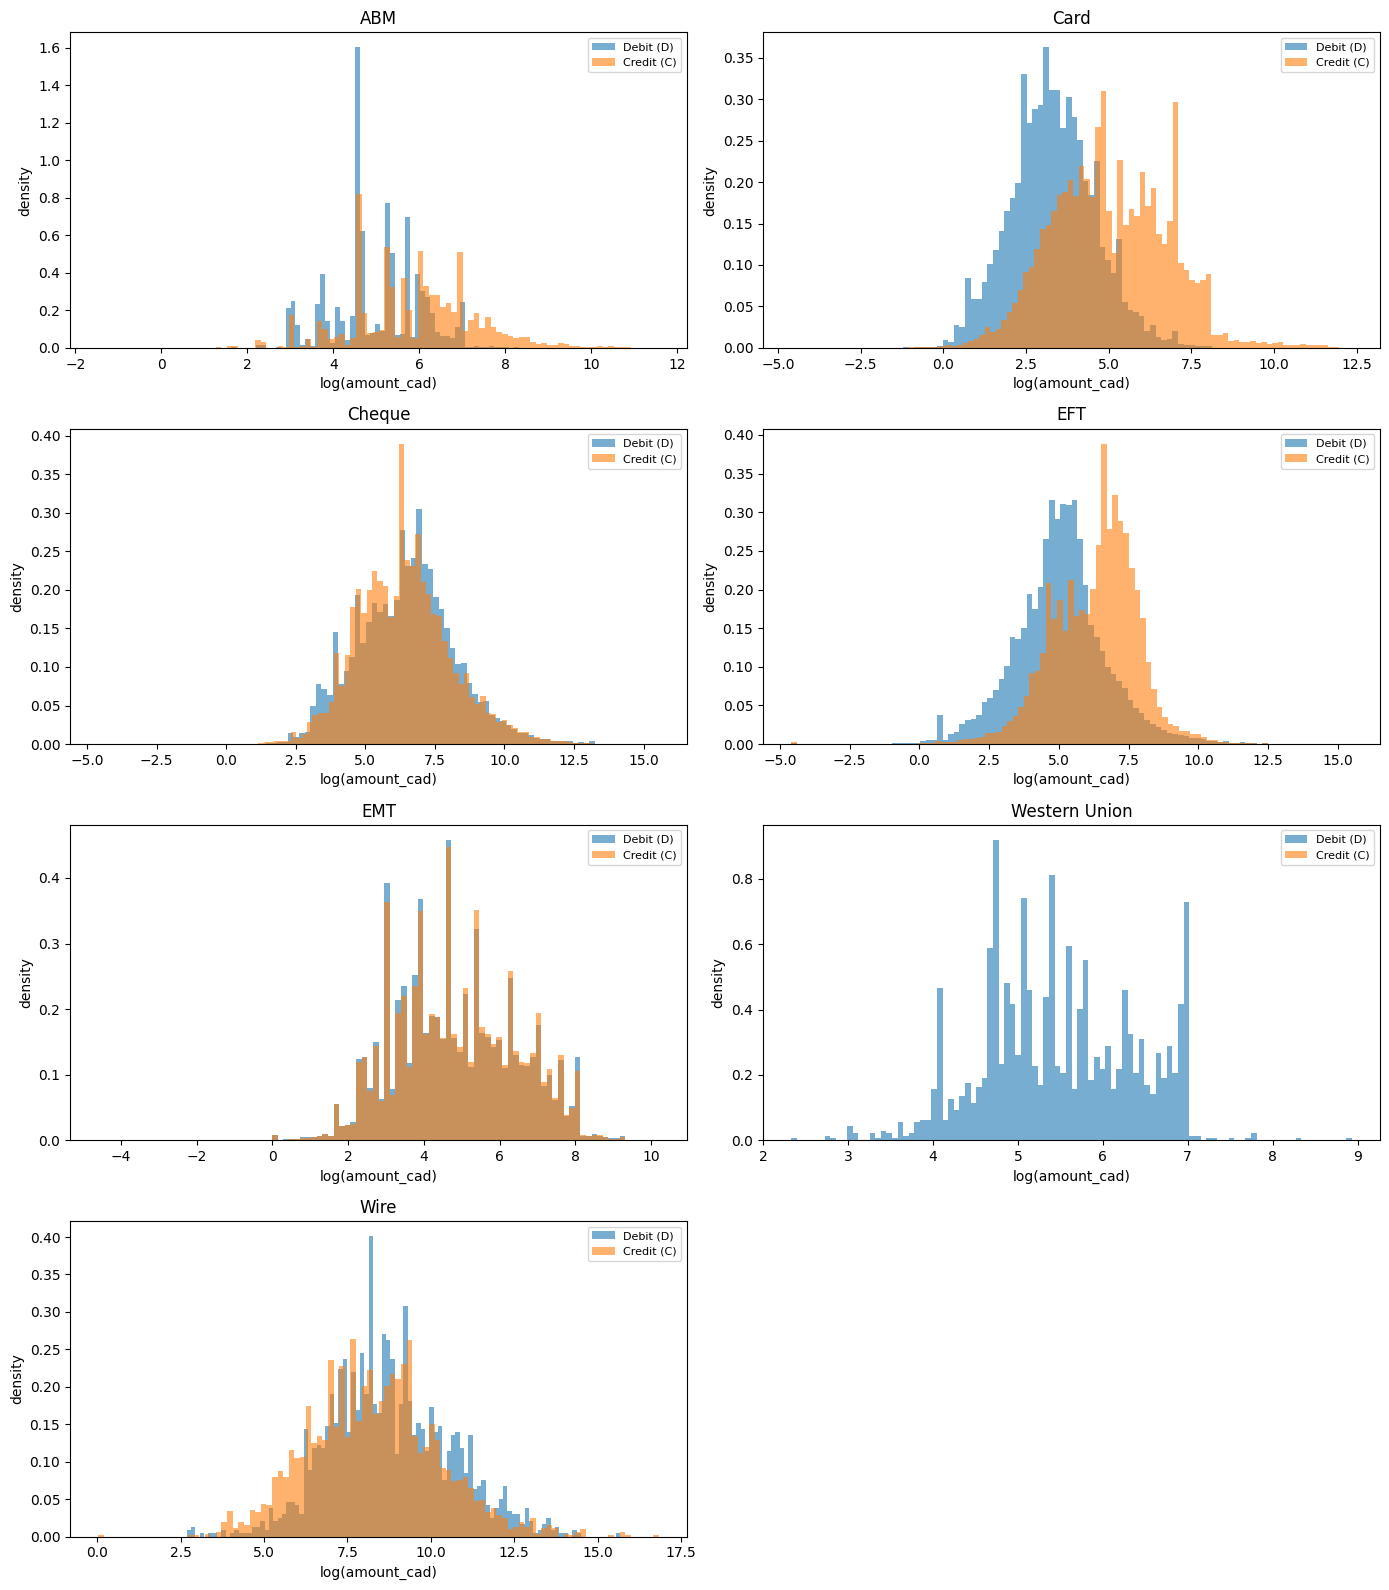

In [78]:
channels = {
    "ABM": abm,
    "Card": card,
    "Cheque": cheque,
    "EFT": eft,
    "EMT": emt,
    "Western Union": westernUnion,
    "Wire": wire
}

def plot_debit_credit_hist(ax, df, title, bins=100):
    amt = pd.to_numeric(df["amount_cad"], errors="coerce")
    df = df.copy()
    df["amount_cad"] = amt
    df = df[df["amount_cad"] > 0]

    dc = df["debit_credit"].astype(str).str.upper().str.strip()
    df["debit_credit"] = dc

    debit = np.log(df.loc[df["debit_credit"] == "D", "amount_cad"])
    credit = np.log(df.loc[df["debit_credit"] == "C", "amount_cad"])

    ax.hist(debit.dropna(), bins=bins, alpha=0.6, density=True, label="Debit (D)")
    ax.hist(credit.dropna(), bins=bins, alpha=0.6, density=True, label="Credit (C)")
    ax.set_title(title)
    ax.set_xlabel("log(amount_cad)")
    ax.set_ylabel("density")
    ax.legend(fontsize=8)

fig, axes = plt.subplots(4, 2, figsize=(14, 16))
axes = axes.flatten()

for i, (name, df) in enumerate(channels.items()):
    plot_debit_credit_hist(axes[i], df, name, bins=100)

for j in range(len(channels), len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()

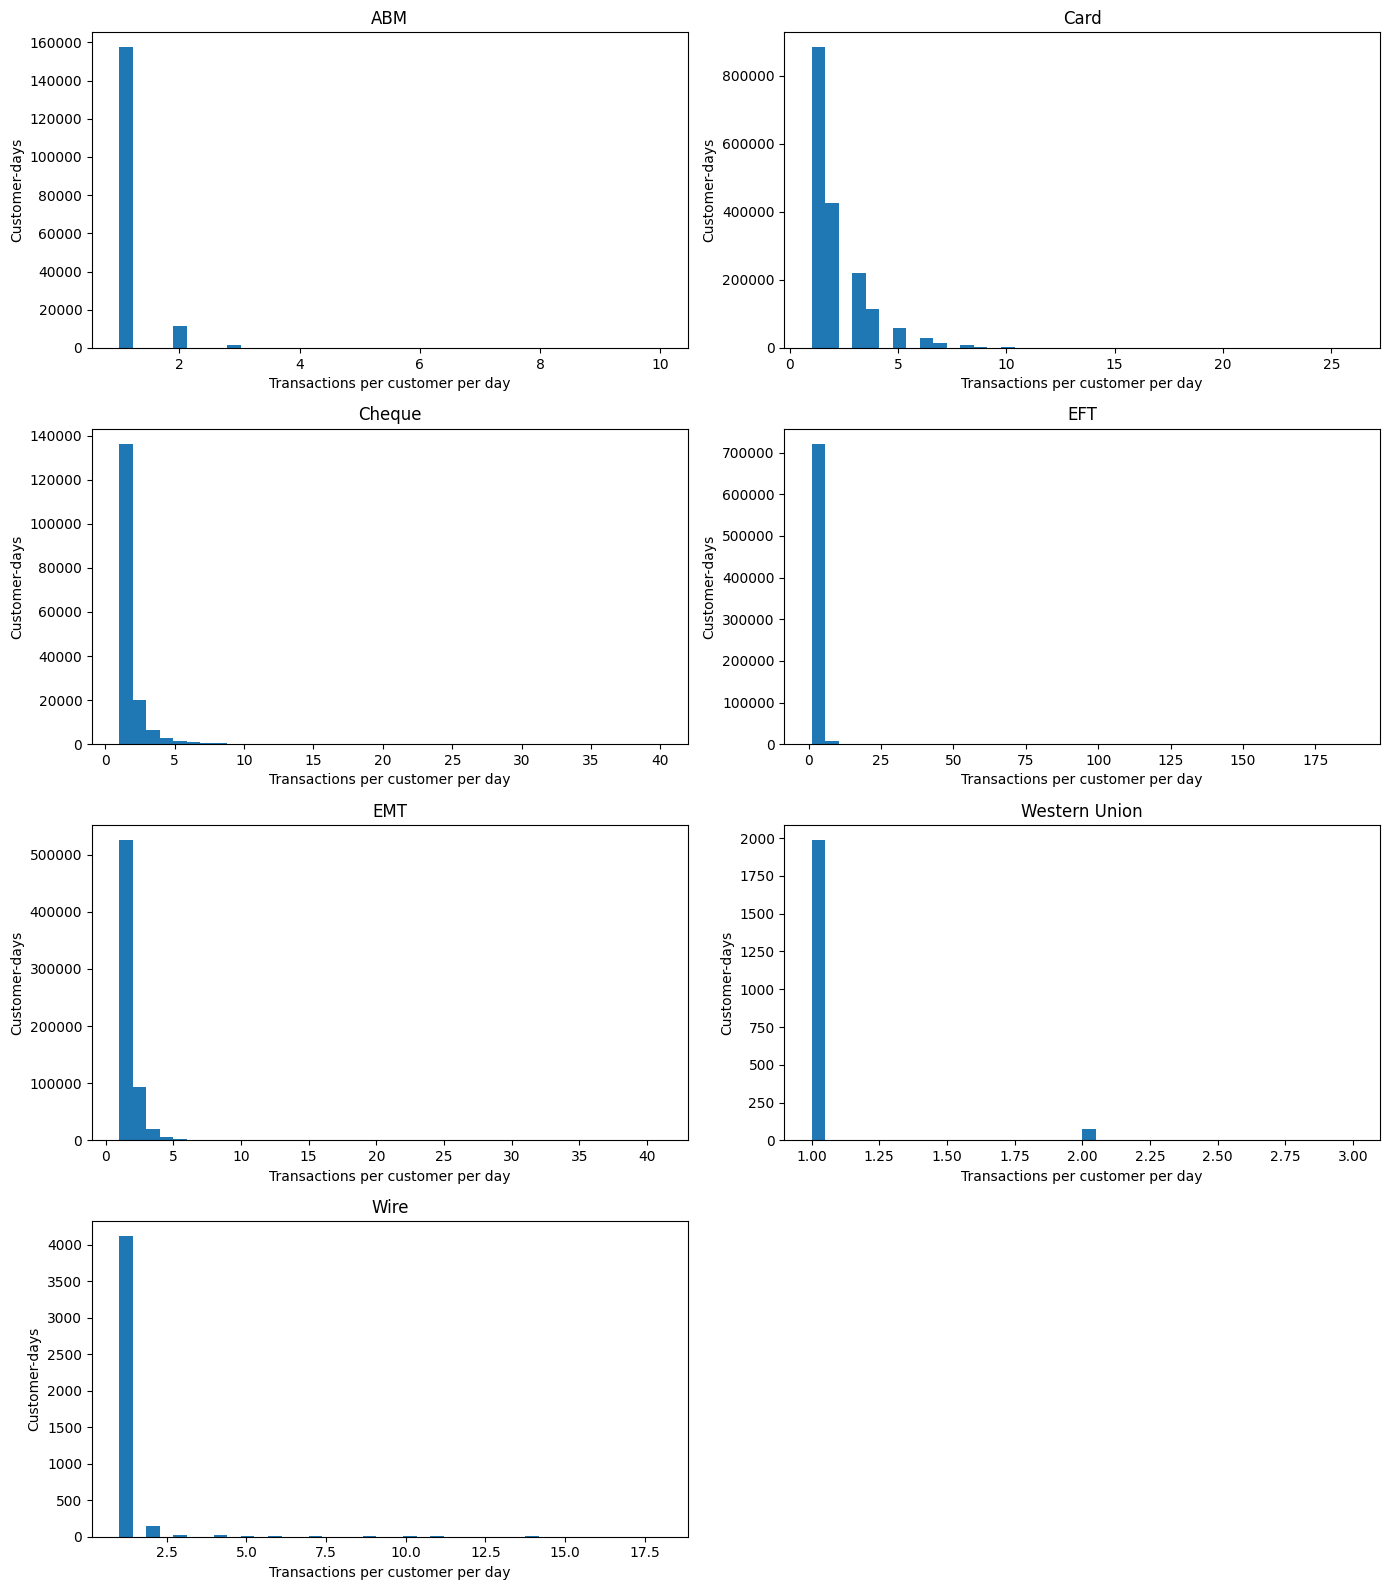

In [79]:
def plot_txns_per_day_hist(ax, df, channel_name, bins=40):
    df = df.copy()
    
    df["transaction_datetime"] = pd.to_datetime(
        df["transaction_datetime"], errors="coerce")
    df["date"] = df["transaction_datetime"].dt.date

    txns_per_day = (
        df.groupby(["customer_id", "date"])
          .size()
          .rename("n_txns")
          .reset_index())

    ax.hist(txns_per_day["n_txns"], bins=bins)
    ax.set_title(channel_name)
    ax.set_xlabel("Transactions per customer per day")
    ax.set_ylabel("Customer-days")

fig, axes = plt.subplots(4, 2, figsize=(14, 16))
axes = axes.flatten()

for i, (name, df) in enumerate(channels.items()):
    plot_txns_per_day_hist(axes[i], df, name)

# turn off extra subplot
for j in range(len(channels), len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()

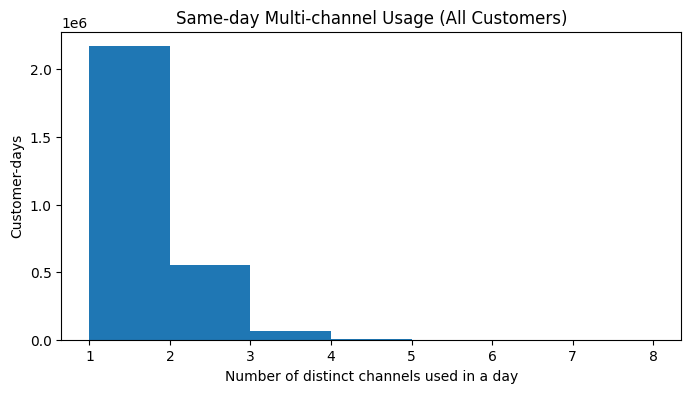

In [80]:
def prep_channel(df, channel_name):
    out = df[["customer_id", "transaction_datetime"]].copy()
    out["transaction_datetime"] = pd.to_datetime(out["transaction_datetime"], errors="coerce")
    out["date"] = out["transaction_datetime"].dt.date
    out["channel"] = channel_name
    return out

all_txns = pd.concat([
    prep_channel(abm, "ABM"),
    prep_channel(card, "Card"),
    prep_channel(cheque, "Cheque"),
    prep_channel(eft, "EFT"),
    prep_channel(emt, "EMT"),
    prep_channel(westernUnion, "WesternUnion"),
    prep_channel(wire, "Wire")
], ignore_index=True)

cust_day_channel = (
    all_txns
    .groupby(["customer_id", "date", "channel"])
    .size()
    .rename("n_txns")
    .reset_index())

channels_per_day = (
    cust_day_channel
    .groupby(["customer_id", "date"])["channel"]
    .nunique()
    .rename("n_channels")
    .reset_index())

plt.figure(figsize=(8,4))
plt.hist(channels_per_day["n_channels"], bins=range(1,9))
plt.xlabel("Number of distinct channels used in a day")
plt.ylabel("Customer-days")
plt.title("Same-day Multi-channel Usage (All Customers)")
plt.show()

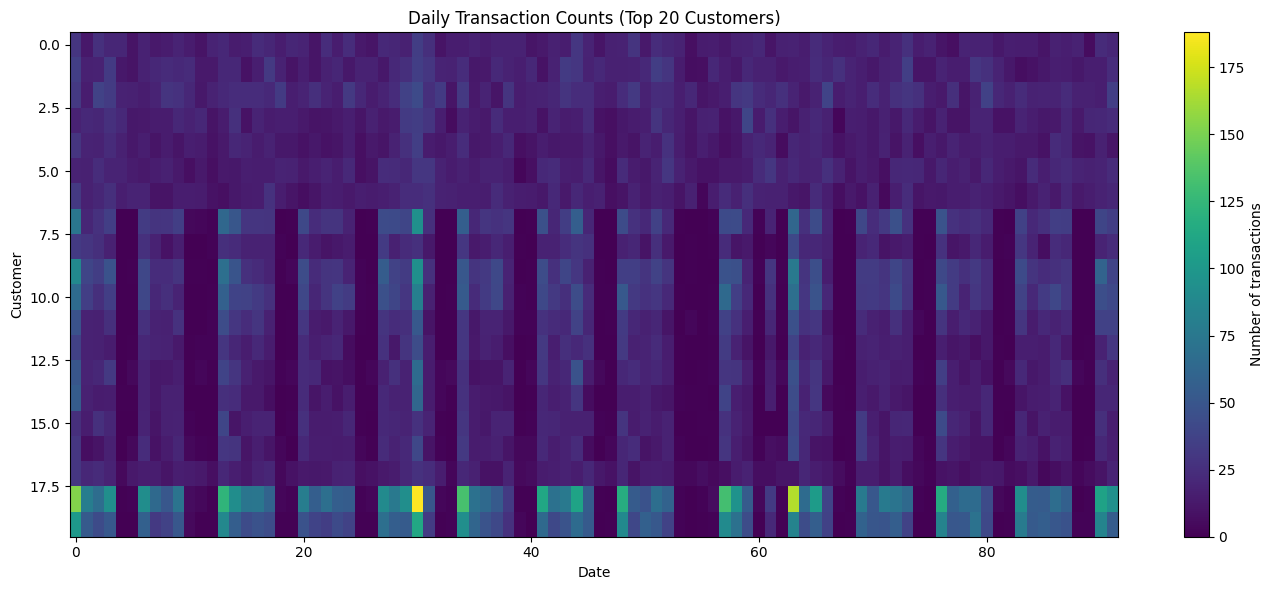

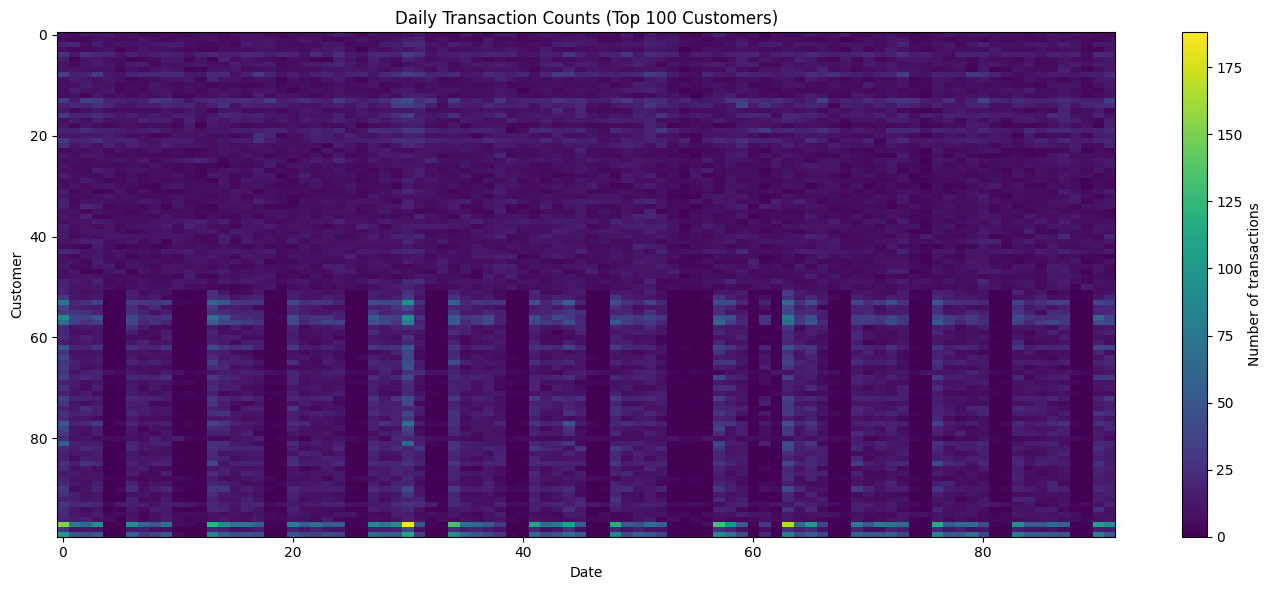

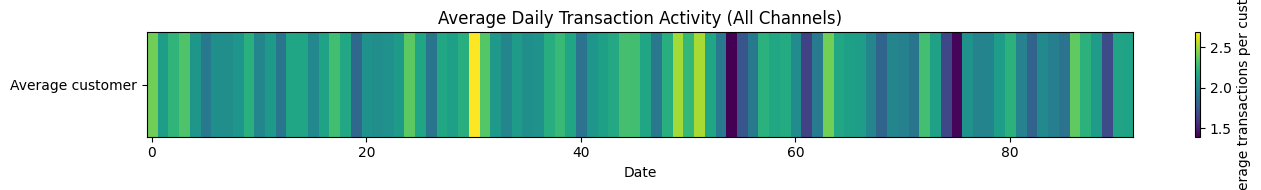

In [81]:
cust_day_counts = (
    all_txns
    .groupby(["customer_id", "date"])
    .size()
    .rename("n_txns")
    .reset_index())

# top 20 customers
top_n = 20

top_customers = (
    cust_day_counts
    .groupby("customer_id")["n_txns"]
    .sum()
    .sort_values(ascending=False)
    .head(top_n)
    .index)

heat_df = cust_day_counts[cust_day_counts["customer_id"].isin(top_customers)]

heat = (
    heat_df
    .pivot(index="customer_id", columns="date", values="n_txns")
    .fillna(0))

plt.figure(figsize=(14, 6))
plt.imshow(heat, aspect="auto")
plt.colorbar(label="Number of transactions")
plt.ylabel("Customer")
plt.xlabel("Date")
plt.title(f"Daily Transaction Counts (Top {top_n} Customers)")
plt.tight_layout()
plt.show()

# top 100 customers 
top100_customers = (
    cust_day_counts
    .groupby("customer_id")["n_txns"]
    .sum()
    .sort_values(ascending=False)
    .head(100)
    .index)

heat_df = cust_day_counts[cust_day_counts["customer_id"].isin(top100_customers)]

heat = (
    heat_df
    .pivot(index="customer_id", columns="date", values="n_txns")
    .fillna(0))

plt.figure(figsize=(14, 6))
plt.imshow(heat, aspect="auto")
plt.colorbar(label="Number of transactions")
plt.ylabel("Customer")
plt.xlabel("Date")
plt.title(f"Daily Transaction Counts (Top 100 Customers)")
plt.tight_layout()
plt.show()

# average 
avg_by_day = (
    cust_day_counts
    .groupby("date")["n_txns"]
    .mean()
    .rename("avg_txns")
    .reset_index())

heat = avg_by_day.set_index("date").T

plt.figure(figsize=(14, 2))
plt.imshow(heat, aspect="auto")
plt.colorbar(label="Average transactions per customer")
plt.yticks([0], ["Average customer"])
plt.xlabel("Date")
plt.title("Average Daily Transaction Activity (All Channels)")
plt.tight_layout()
plt.show()

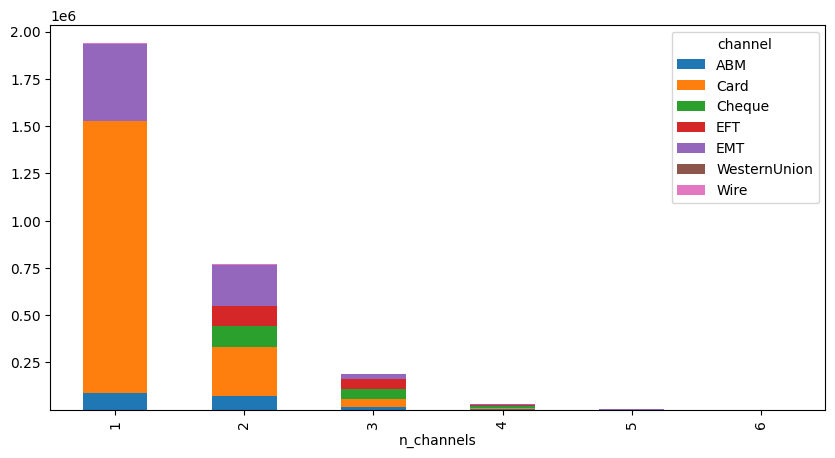

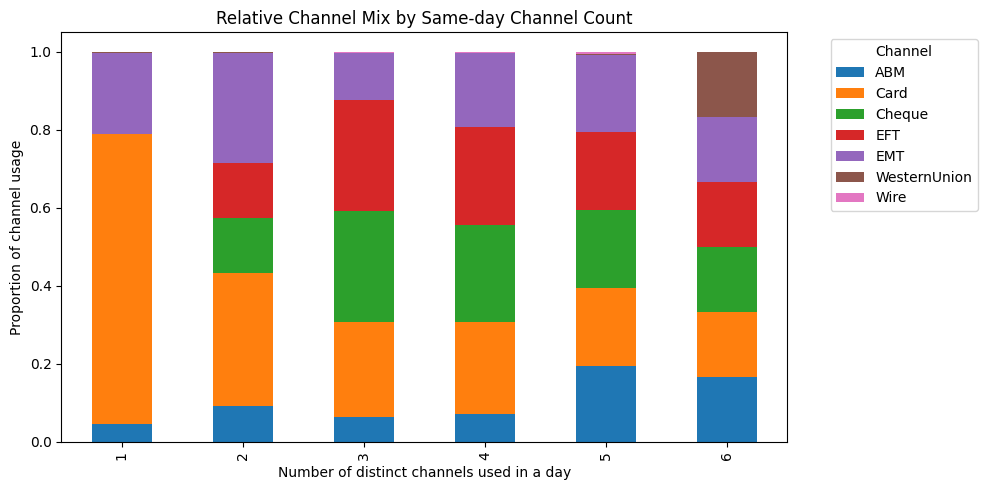

In [25]:
channel_mix = (
    cust_day_channel
    .merge(channels_per_day, on=["customer_id", "date"])
    .groupby(["n_channels", "channel"])
    .size()
    .rename("count")
    .reset_index())

mix_pivot = (
    channel_mix
    .pivot(index="n_channels", columns="channel", values="count")
    .fillna(0))

mix_pivot.plot(
    kind="bar",
    stacked=True,
    figsize=(10,5))

mix_prop = mix_pivot.div(mix_pivot.sum(axis=1), axis=0)

mix_prop.plot(
    kind="bar",
    stacked=True,
    figsize=(10,5))

plt.xlabel("Number of distinct channels used in a day")
plt.ylabel("Proportion of channel usage")
plt.title("Relative Channel Mix by Same-day Channel Count")
plt.legend(title="Channel", bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()

# KYC

In [28]:
kyc_ind = pd.read_csv("kyc_individual.csv")
kyc_ind.head()

,customer_id,country,province,city,gender,marital_status,occupation_code,income,birth_date,onboard_date
0,SYNID0100000167,CA,ON,TORONTO,NaN,Married,10019,48886.0,1972-01-30,2011-09-20
1,SYNID0100000431,CA,NaN,other,FEMALE,Married,72310,NaN,1988-03-20,2018-06-04
2,SYNID0100000485,CA,ON,BRAMPTON,FEMALE,Widowed,RETIRED,19998.0,1935-05-02,1997-07-12
3,SYNID0100000539,CA,NaN,other,MALE,Widowed,RETIRED,39417.0,1944-11-04,1985-05-14
4,SYNID0100000932,CA,ON,TORONTO,FEMALE,Married,RETIRED,34182.0,1963-09-14,2012-07-09


In [29]:
kyc_ind_codes = pd.read_csv("kyc_industry_codes.csv")
kyc_ind_codes.head()

,industry_code,industry
0,112,Cattle Farms
1,119,Livestock Combination Farms
2,139,Other Field Crop Farms
3,141,Field Crop Combination Farms
4,171,"Livestock, Field Crop and Horticultural Combin..."


In [30]:
kyc_occ_codes = pd.read_csv("kyc_occupation_codes.csv")
kyc_occ_codes.head()

,occupation_code,occupation_title
0,0,Legislative and senior management occupations
1,10010,Financial managers
2,10011,Human resources managers
3,10019,Other administrative services managers
4,10029,Other business services managers


In [31]:
kyc_sb = pd.read_csv("kyc_smallbusiness.csv")
kyc_sb.head()

,customer_id,country,province,city,industry_code,employee_count,sales,established_date,onboard_date
0,SYNID0200000024,CA,ON,BRAMPTON,9699,5.0,181876.0,2022-12-09,2022-12-26
1,SYNID0200000050,CA,ON,TORONTO,4214,1.0,250009.0,1991-02-24,1996-06-17
2,SYNID0200000104,CA,AB,EDMONTON,7215,2.0,217904.0,2011-06-20,NaN
3,SYNID0200000167,CA,NaN,other,8649,1.0,0.0,2024-02-20,2024-11-27
4,SYNID0200000345,CA,NaN,other,9861,NaN,NaN,2003-12-08,2003-12-18


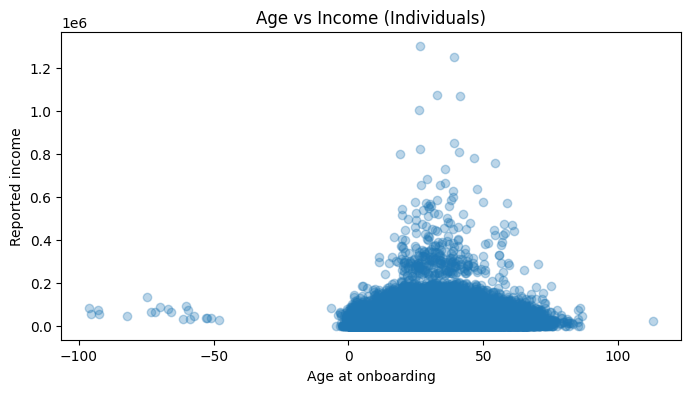

In [33]:
kyc_ind = kyc_ind.copy()

kyc_ind["birth_date"] = pd.to_datetime(kyc_ind["birth_date"], errors="coerce")
kyc_ind["onboard_date"] = pd.to_datetime(kyc_ind["onboard_date"], errors="coerce")

kyc_ind["age"] = (
    (kyc_ind["onboard_date"] - kyc_ind["birth_date"])
    .dt.days / 365.25
)

plt.figure(figsize=(8,4))
plt.scatter(kyc_ind["age"], kyc_ind["income"], alpha=0.3)
plt.xlabel("Age at onboarding")
plt.ylabel("Reported income")
plt.title("Age vs Income (Individuals)")
plt.show()

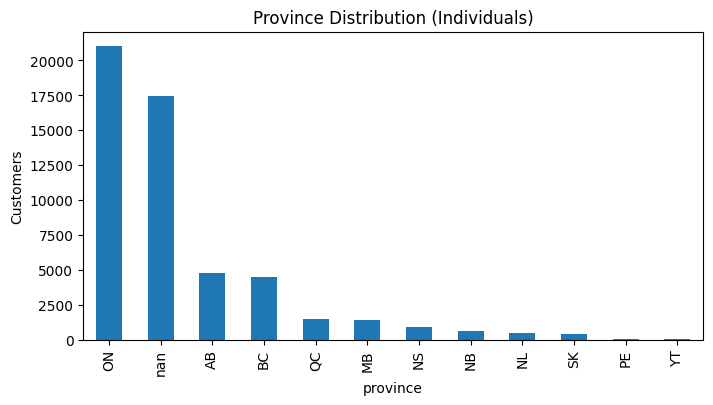

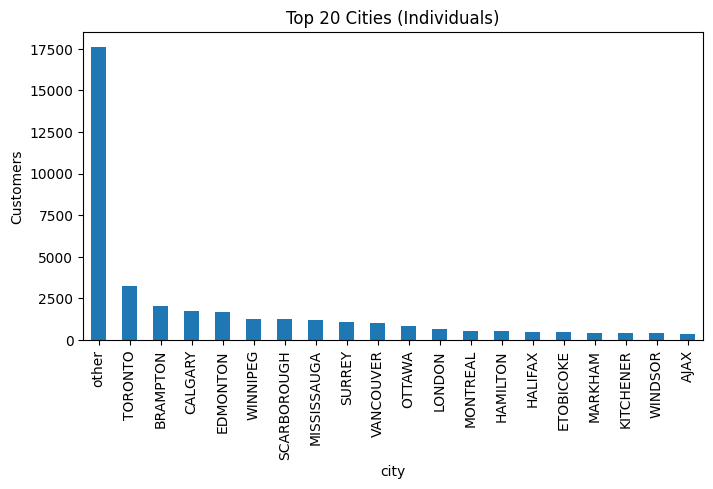

In [37]:
plt.figure(figsize=(8,4))
kyc_ind["province"].value_counts(dropna=False).plot(kind="bar")
plt.title("Province Distribution (Individuals)")
plt.ylabel("Customers")
plt.show()

plt.figure(figsize=(8,4))
kyc_ind["city"].value_counts().head(20).plot(kind="bar")
plt.title("Top 20 Cities (Individuals)")
plt.ylabel("Customers")
plt.show()

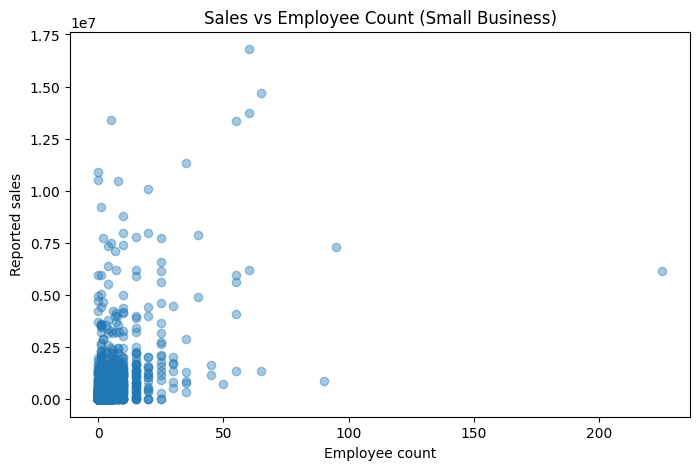

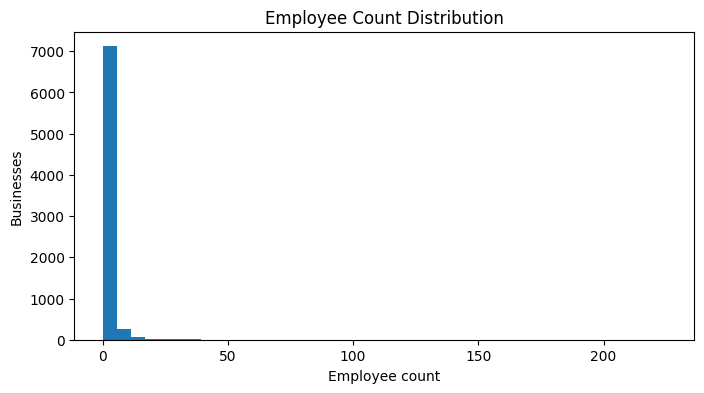

In [39]:
plt.figure(figsize=(8,5))
plt.scatter(
    kyc_sb["employee_count"],
    kyc_sb["sales"],
    alpha=0.4
)
plt.xlabel("Employee count")
plt.ylabel("Reported sales")
plt.title("Sales vs Employee Count (Small Business)")
plt.show()

plt.figure(figsize=(8,4))
plt.hist(kyc_sb["employee_count"].dropna(), bins=40)
plt.xlabel("Employee count")
plt.ylabel("Businesses")
plt.title("Employee Count Distribution")
plt.show()

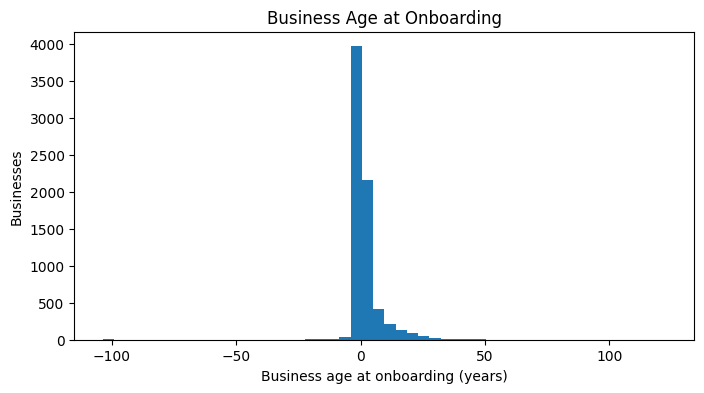

In [40]:
kyc_sb["established_date"] = pd.to_datetime(kyc_sb["established_date"], errors="coerce")
kyc_sb["onboard_date"] = pd.to_datetime(kyc_sb["onboard_date"], errors="coerce")

kyc_sb["business_age"] = (
    (kyc_sb["onboard_date"] - kyc_sb["established_date"])
    .dt.days / 365.25
)

plt.figure(figsize=(8,4))
plt.hist(kyc_sb["business_age"].dropna(), bins=50)
plt.xlabel("Business age at onboarding (years)")
plt.ylabel("Businesses")
plt.title("Business Age at Onboarding")
plt.show()

In [47]:
kyc_ind_fix = kyc_ind.copy()
kyc_occ_fix = kyc_occ_codes.copy()

kyc_ind_fix["occupation_code_num"] = pd.to_numeric(
    kyc_ind_fix["occupation_code"],
    errors="coerce")

kyc_occ_fix["occupation_code_num"] = pd.to_numeric(
    kyc_occ_fix["occupation_code"],
    errors="coerce")

kyc_ind_occ = kyc_ind_fix.merge(
    kyc_occ_fix[["occupation_code_num", "occupation_title"]],
    on="occupation_code_num",
    how="left")

kyc_sb_fix = kyc_sb.copy()
kyc_ind_codes_fix = kyc_ind_codes.copy()

kyc_sb_fix["industry_code_num"] = pd.to_numeric(
    kyc_sb_fix["industry_code"],
    errors="coerce")

kyc_ind_codes_fix["industry_code_num"] = pd.to_numeric(
    kyc_ind_codes_fix["industry_code"],
    errors="coerce")

kyc_sb_ind = kyc_sb_fix.merge(
    kyc_ind_codes_fix[["industry_code_num", "industry"]],
    on="industry_code_num",
    how="left")

<Figure size 1000x400 with 0 Axes>

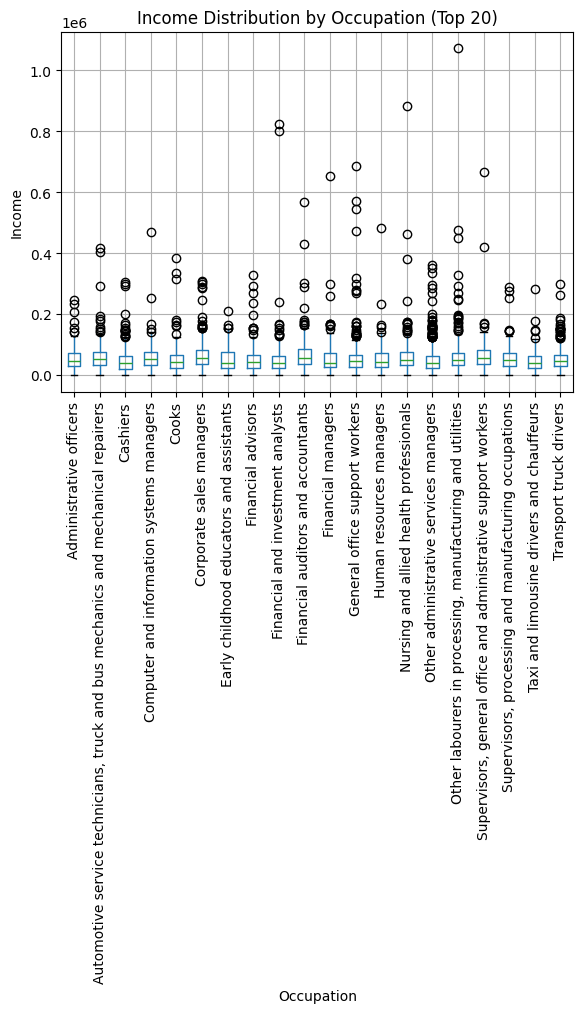

In [49]:
top_occ = (
    kyc_ind_occ["occupation_title"]
    .value_counts()
    .head(20)
    .index
)

plt.figure(figsize=(10,4))
kyc_ind_occ[kyc_ind_occ["occupation_title"].isin(top_occ)] \
    .boxplot(
        column="income",
        by="occupation_title",
        rot=90
    )

plt.title("Income Distribution by Occupation (Top 20)")
plt.suptitle("")
plt.xlabel("Occupation")
plt.ylabel("Income")
plt.show()

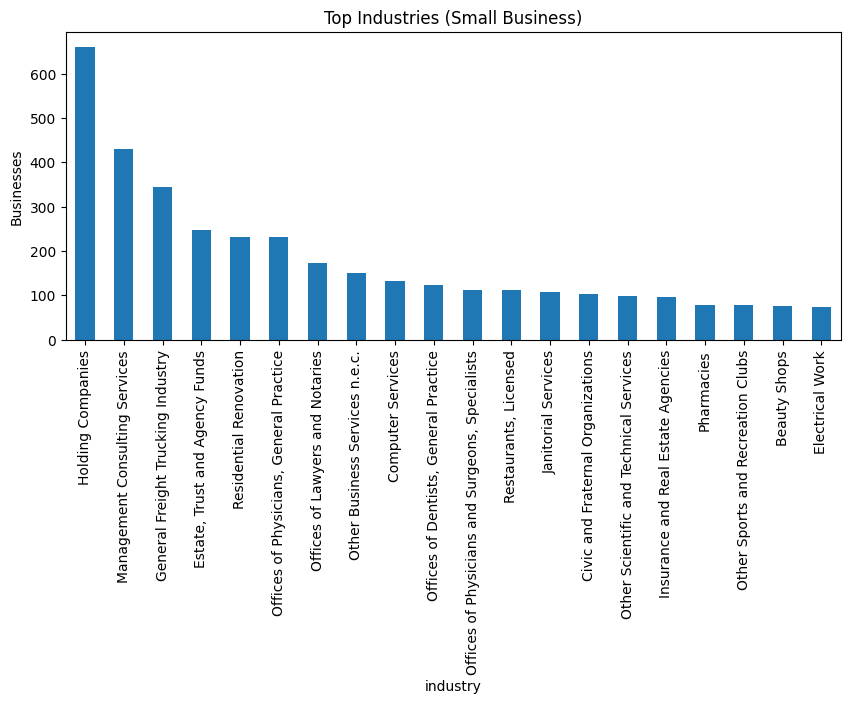

In [50]:
top_industries = (
    kyc_sb_ind["industry"]
    .value_counts()
    .head(20)
    .index
)

plt.figure(figsize=(10,4))
kyc_sb_ind[kyc_sb_ind["industry"].isin(top_industries)] \
    .groupby("industry")["customer_id"] \
    .count() \
    .sort_values(ascending=False) \
    .plot(kind="bar")

plt.ylabel("Businesses")
plt.title("Top Industries (Small Business)")
plt.show()

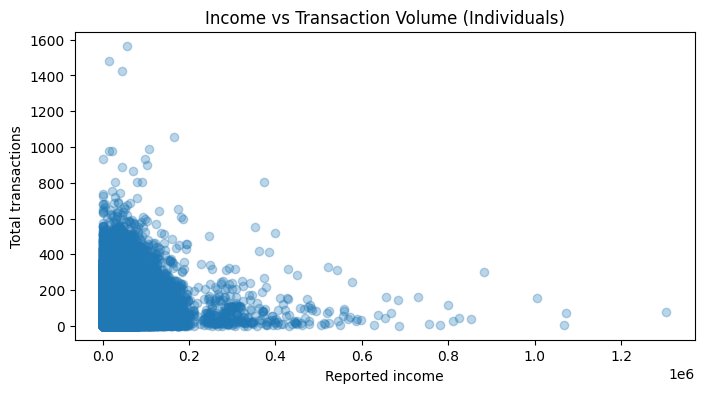

In [51]:
txn_counts = (
    all_txns
    .groupby("customer_id")
    .size()
    .rename("total_txns")
    .reset_index()
)

ind_txn = txn_counts.merge(
    kyc_ind[["customer_id","income"]],
    on="customer_id",
    how="left"
)

plt.figure(figsize=(8,4))
plt.scatter(ind_txn["income"], ind_txn["total_txns"], alpha=0.3)
plt.xlabel("Reported income")
plt.ylabel("Total transactions")
plt.title("Income vs Transaction Volume (Individuals)")
plt.show()

# Label

In [53]:
label = pd.read_csv("labels.csv")
label.head()

,customer_id,label
0,SYNID0100000485,0
1,SYNID0100021236,0
2,SYNID0100036671,0
3,SYNID0100059315,0
4,SYNID0100060562,0


In [57]:
label["label"].value_counts()

label
0    990
1     10
Name: count, dtype: int64

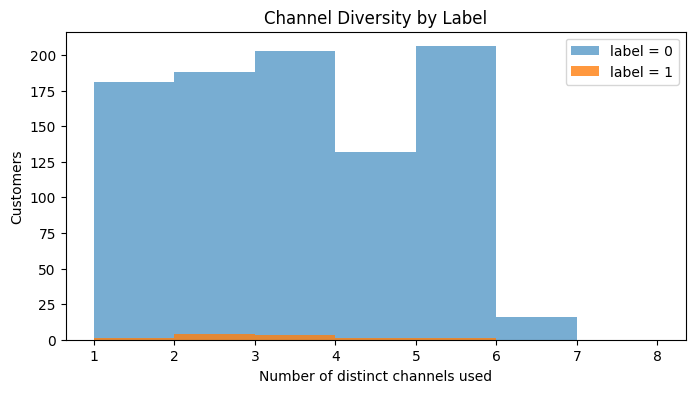

In [58]:
cust_channels = (
    all_txns
    .groupby("customer_id")["channel"]
    .nunique()
    .rename("n_channels")
    .reset_index())

cust_channels = cust_channels.merge(label, on="customer_id", how="left")

plt.figure(figsize=(8,4))
plt.hist(
    cust_channels.loc[cust_channels["label"] == 0, "n_channels"],
    bins=range(1,9),
    alpha=0.6,
    label="label = 0")
plt.hist(
    cust_channels.loc[cust_channels["label"] == 1, "n_channels"],
    bins=range(1,9),
    alpha=0.8,
    label="label = 1")
plt.xlabel("Number of distinct channels used")
plt.ylabel("Customers")
plt.title("Channel Diversity by Label")
plt.legend()
plt.show()

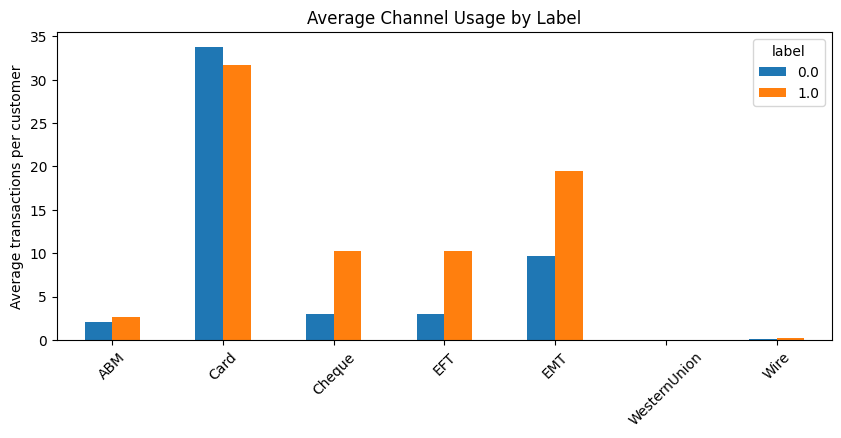

In [60]:
channel_counts = (
    all_txns
    .groupby(["customer_id","channel"])
    .size()
    .unstack(fill_value=0)
    .reset_index())

channel_counts = channel_counts.merge(label, on="customer_id", how="left")

channel_means = channel_counts.groupby("label").mean(numeric_only=True)

channel_means.T.plot(kind="bar", figsize=(10,4))
plt.ylabel("Average transactions per customer")
plt.title("Average Channel Usage by Label")
plt.xticks(rotation=45)
plt.show()

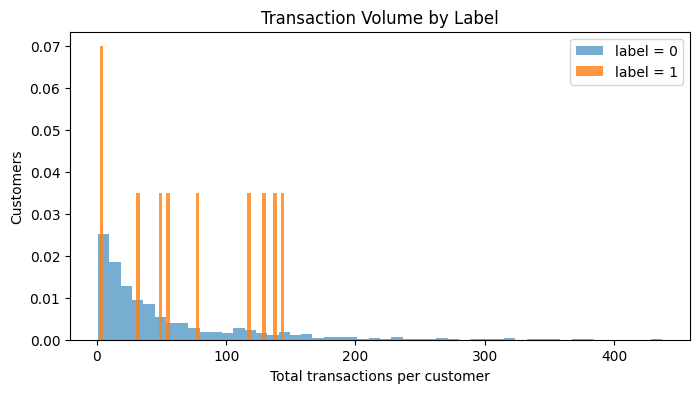

/tmp/ipykernel_1772664/3117030326.py:30: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


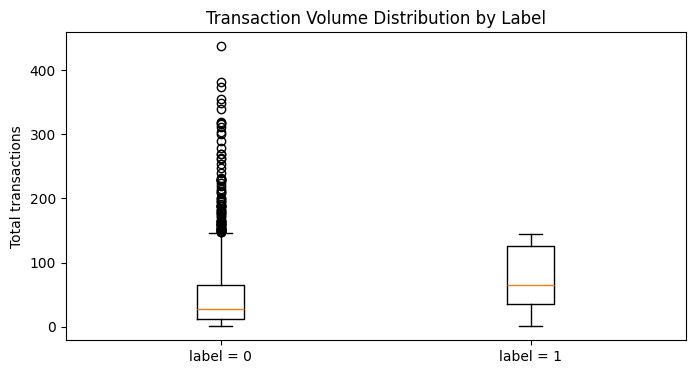

In [74]:
txn_counts = (
    all_txns
    .groupby("customer_id")
    .size()
    .rename("total_txns")
    .reset_index())

txn_counts = txn_counts.merge(label, on="customer_id", how="left")

plt.figure(figsize=(8,4))
plt.hist(
    txn_counts.loc[txn_counts["label"] == 0, "total_txns"],
    bins=50,
    alpha=0.6,
    label="label = 0",
    density=True)
plt.hist(
    txn_counts.loc[txn_counts["label"] == 1, "total_txns"],
    bins=50,
    alpha=0.8,
    label="label = 1",
    density=True)
plt.xlabel("Total transactions per customer")
plt.ylabel("Customers")
plt.title("Transaction Volume by Label")
plt.legend()
plt.show()

plt.figure(figsize=(8,4))
plt.boxplot(
    [
        txn_counts.loc[txn_counts["label"] == 0, "total_txns"],
        txn_counts.loc[txn_counts["label"] == 1, "total_txns"]
    ],
    labels=["label = 0", "label = 1"]
)
plt.ylabel("Total transactions")
plt.title("Transaction Volume Distribution by Label")
plt.show()

/tmp/ipykernel_1772664/3504367151.py:37: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


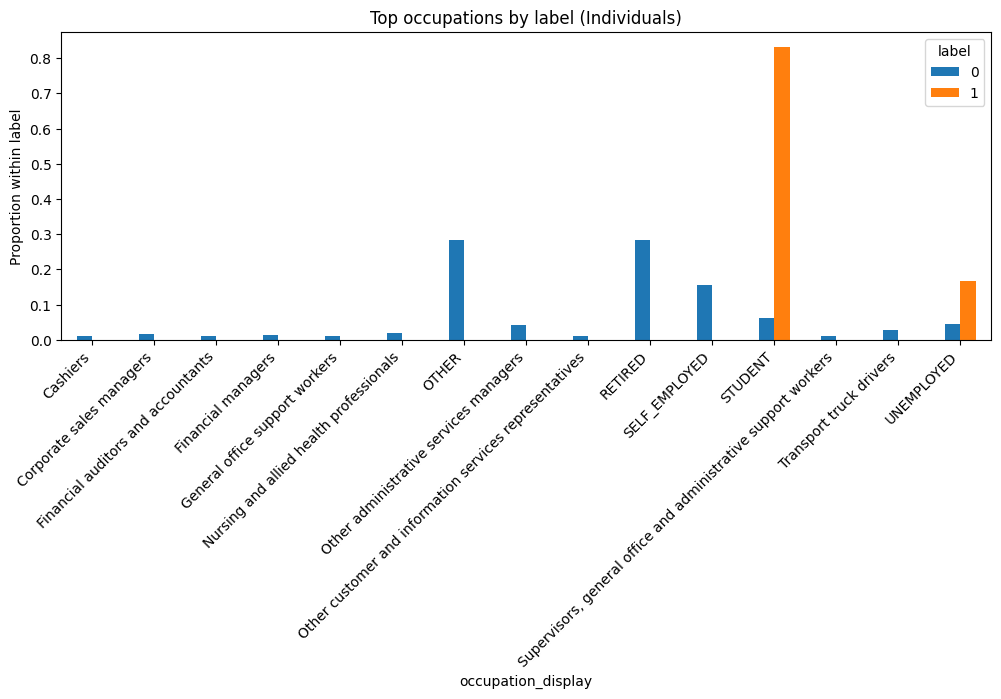

In [69]:
kyc_ind_fix = kyc_ind.copy()
occ = kyc_occ_codes.copy()

# numeric join for coded occupations
kyc_ind_fix["occupation_code_num"] = pd.to_numeric(kyc_ind_fix["occupation_code"], errors="coerce")
occ["occupation_code_num"] = pd.to_numeric(occ["occupation_code"], errors="coerce")

kyc_ind_occ = kyc_ind_fix.merge(
    occ[["occupation_code_num", "occupation_title"]],
    on="occupation_code_num",
    how="left"
)

# "display" occupation: use title if available, else fall back to raw occupation_code (e.g., RETIRED)
kyc_ind_occ["occupation_display"] = kyc_ind_occ["occupation_title"]
kyc_ind_occ["occupation_display"] = kyc_ind_occ["occupation_display"].fillna(kyc_ind_occ["occupation_code"].astype(str))
kyc_ind_occ["occupation_display"] = kyc_ind_occ["occupation_display"].fillna("Unknown")

ind_labels = kyc_ind_occ.merge(label, on="customer_id", how="inner")

top_occ = ind_labels["occupation_display"].value_counts().head(15).index

occ_counts = (
    ind_labels[ind_labels["occupation_display"].isin(top_occ)]
    .groupby(["label","occupation_display"])
    .size()
    .unstack(fill_value=0)
)

# normalize within label for proportions
occ_props = occ_counts.div(occ_counts.sum(axis=1), axis=0)

occ_props.T.plot(kind="bar", figsize=(12,4))
plt.ylabel("Proportion within label")
plt.title("Top occupations by label (Individuals)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,4))
plt.boxplot(
    [ind_labels.loc[ind_labels["label"]==0, "income"].dropna(),
     ind_labels.loc[ind_labels["label"]==1, "income"].dropna()],
    labels=["label=0", "label=1"]
)
plt.ylabel("Income")
plt.title("Income by label (Individuals)")
plt.show()

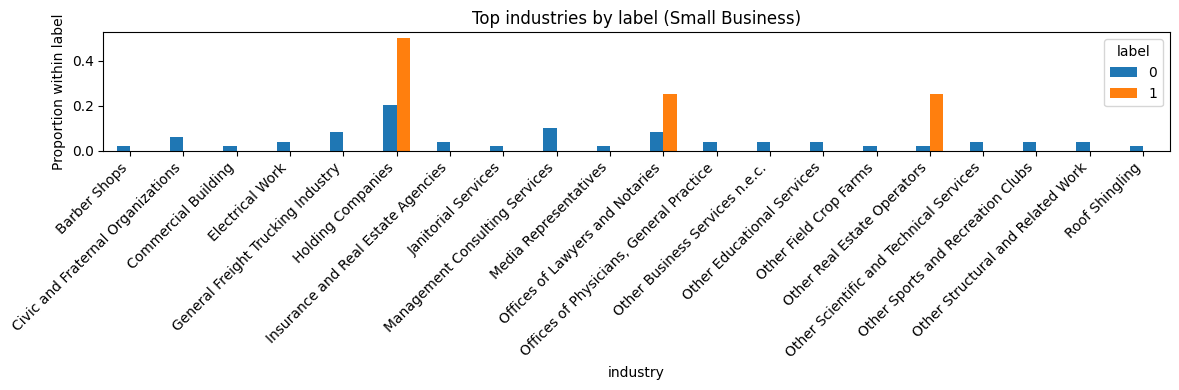

In [72]:
kyc_sb_fix = kyc_sb.copy()
indc = kyc_ind_codes.copy()

kyc_sb_fix["industry_code_num"] = pd.to_numeric(kyc_sb_fix["industry_code"], errors="coerce")
indc["industry_code_num"] = pd.to_numeric(indc["industry_code"], errors="coerce")

kyc_sb_ind = kyc_sb_fix.merge(
    indc[["industry_code_num", "industry"]],
    on="industry_code_num",
    how="left"
)

sb_labels = kyc_sb_ind.merge(label, on="customer_id", how="inner")

top_ind = sb_labels["industry"].value_counts().head(20).index

ind_counts = (
    sb_labels[sb_labels["industry"].isin(top_ind)]
    .groupby(["label","industry"])
    .size()
    .unstack(fill_value=0)
)
ind_props = ind_counts.div(ind_counts.sum(axis=1), axis=0)

ind_props.T.plot(kind="bar", figsize=(12,4))
plt.ylabel("Proportion within label")
plt.title("Top industries by label (Small Business)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

/tmp/ipykernel_1772664/4249088259.py:2: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


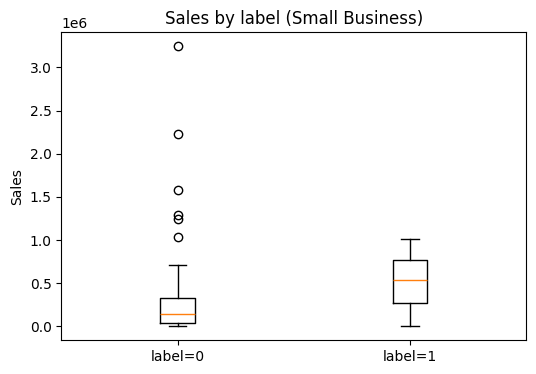

/tmp/ipykernel_1772664/4249088259.py:12: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


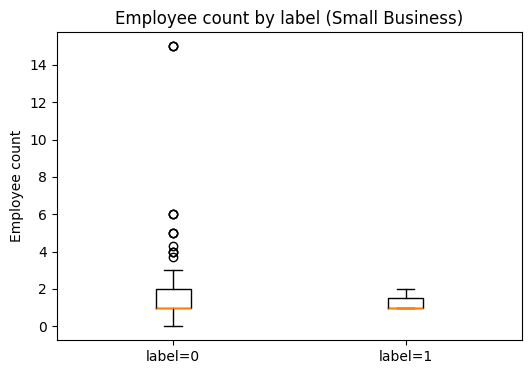

In [73]:
plt.figure(figsize=(6,4))
plt.boxplot(
    [sb_labels.loc[sb_labels["label"]==0, "sales"].dropna(),
     sb_labels.loc[sb_labels["label"]==1, "sales"].dropna()],
    labels=["label=0", "label=1"]
)
plt.ylabel("Sales")
plt.title("Sales by label (Small Business)")
plt.show()

plt.figure(figsize=(6,4))
plt.boxplot(
    [sb_labels.loc[sb_labels["label"]==0, "employee_count"].dropna(),
     sb_labels.loc[sb_labels["label"]==1, "employee_count"].dropna()],
    labels=["label=0", "label=1"]
)
plt.ylabel("Employee count")
plt.title("Employee count by label (Small Business)")
plt.show()